# Crime Analysis and Prediction

This file contains a set of experiments for analyzing and extrapolating data regarding crimes.

## 1. Data Loading and Sanitization

In [101]:
import csv
import matplotlib.pyplot as plt

def chicago_from(row, params=None):
    '''
    Method which takes a row from the chichago data and returns a Crime representing that row
    '''
    city = "CHICAGO"
    date_intermediate = row[3].split(" ")
    date = date_intermediate[0]
    time = date_intermediate[1] + date_intermediate[2]
    crime = row[6]
    location = (float(row[-2][2:]), float(row[-1][0:-2]))
    return Crime(city, date, time, crime, None, None, None, location)
     

config = {
    "root_data": "data/",
    "LA_crime": "crime-in-los-angeles/Crime_Data_2010_2017.csv",
    "CH_crime": "crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv",
    #"LA_schema": {'date': 2, 'time': 3, 'crime': 8, 'victim_age': 10, 'victim_sex': 11, 'weapon': 16, 'location': 25},
    "CH_schema": chicago_from
}

# LA: ['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred', 'Area ID', 'Area Name', 'Reporting District', 'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description', 'Weapon Used Code', 'Weapon Description', 'Status Code', 'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3', 'Crime Code 4', 'Address', 'Cross Street', 'Location']

class Crime:
    
    def __init__(self, city, date, time, crime, victim_age, victim_sex, weapon, location):
        self.city = city
        self.date = date
        self.time = time
        self.crime = crime
        self.victim_age = victim_age
        self.victim_sex = victim_sex
        self.weapon = weapon
        self.location = location
        
    def __str__(self):
        return self.crime + " at " + str(self.time)
        

def load_data(force_refresh=False):
    
    #all_data = {"LA": [], "CH": []}
    all_data = {"CH": []}
    
    for city in all_data.keys():
        data_file = config["root_data"] + config[city + "_crime"]
        parse_from = config[city + "_schema"]
        with open(data_file) as csvfile:
            content = csvfile.readlines()
            content = [x.strip() for x in content]
            del content[0] # Remove the header
            all_data[city].append([])
            
            # Save the number of possible rows available
            all_data[city].append(len(content))
            
            count = 0
            for row in content:
                try:
                    d = row.split(",")
                    new_crime = parse_from(d)
                    all_data[city][0].append(new_crime)
                except:
                    count = count + 1
                    
            # Save the number of errored rows
            all_data[city].append(count)
            
    return all_data

results = load_data()
print(results["CH"][1])

1456714


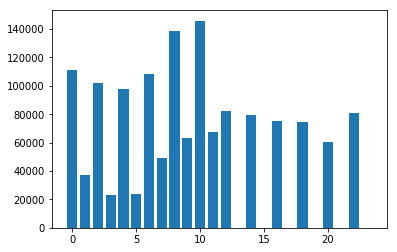

In [104]:
# Some quick analysis of the data we have loaded
buckets = [0]*(24) # Buckets for each half hour (i.e. 00:00 - 00:30)
for crime in results["CH"][0]:
    time = str(crime.time)
    mod = 2 if "PM" in time else 1 # This could be made faster
    comps = time.split(":")
    bucket = ((int(comps[0]) - 1) * mod * 60 + int(comps[1])) / 60
    buckets[bucket] += 1

plt.bar(range(len(buckets)), buckets)
plt.show()